In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
data_dir = 'Colon_image_set/colon_image_sets' 

In [3]:
# Define the mapping from folder names to binary labels
label_mapping = {
    'colon_n': 0,   # benign
    'colon_aca': 1  # malignant
}

In [4]:
# Create a list to hold image paths and labels
data = []
image_count = {0: 0, 1: 0}  # To keep track of image counts for each label

# Iterate through the folders and label the images
for folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder)
    
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        label = label_mapping.get(folder, None)
        if label is not None:
            print(f"Processing folder: {folder}")
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                data.append((image_path, label))
                image_count[label] += 1  # Increment the count for the corresponding label
        else:
            print(f"Warning: No label found for folder {folder}")

Processing folder: colon_aca
Processing folder: colon_n


In [5]:
# Define the directory containing the image sets
data_dir = 'Colon_image_set/colon_image_sets'
filepaths = []
labels = []

# Get the list of classes (subdirectories)
classes = os.listdir(data_dir)
for fold in classes:
    foldpath = os.path.join(data_dir, fold)
    if os.path.isdir(foldpath):
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)

# Create a DataFrame from the lists
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [6]:
# Separate images by class
colon_aca = df[df['labels'] == 'colon_aca']
colon_n = df[df['labels'] == 'colon_n']

# Create training and testing sets
train_colon_aca = colon_aca.sample(frac=0.7, random_state=42)
test_colon_aca = colon_aca.drop(train_colon_aca.index)

train_colon_n = colon_n.sample(frac=0.7, random_state=42)
test_colon_n = colon_n.drop(train_colon_n.index)

train_df = pd.concat([train_colon_aca, train_colon_n], ignore_index=True)
test_df = pd.concat([test_colon_aca, test_colon_n], ignore_index=True)

# Print the sizes of the training and testing sets
print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 7000
Testing set size: 3000


In [7]:
train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['labels'], random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 7000
Testing set size: 3000


In [7]:
# Create ImageDataGenerators
train_datagen = ImageDataGenerator()  # No augmentation
test_datagen = ImageDataGenerator()  # No augmentation

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16  # Adjust as necessary
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=16
)


Found 7000 validated image filenames belonging to 2 classes.
Found 3000 validated image filenames belonging to 2 classes.


In [8]:
# Check class distribution in training set
train_class_distribution = train_df['labels'].value_counts()
print("Training Set Class Distribution:")
print(train_class_distribution)

# Check class distribution in testing set
test_class_distribution = test_df['labels'].value_counts()
print("\nTesting Set Class Distribution:")
print(test_class_distribution)

Training Set Class Distribution:
labels
colon_aca    3500
colon_n      3500
Name: count, dtype: int64

Testing Set Class Distribution:
labels
colon_aca    1500
colon_n      1500
Name: count, dtype: int64


In [14]:
from keras.applications import VGG16
from keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  

In [15]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))  # Change 2 if you have more classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 21137986 (80.64 MB)
Trainable params: 6423298 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,  
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
438/438 [==============================] - ETA: 0s - loss: 1.5922 - accuracy: 0.9627

C:\Users\gillb\anaconda3\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


438/438 [==============================] - 3210s 7s/step - loss: 1.5922 - accuracy: 0.9627 - val_loss: 0.0319 - val_accuracy: 0.9900
Epoch 2/10
438/438 [==============================] - 2785s 6s/step - loss: 0.0568 - accuracy: 0.9839 - val_loss: 0.0273 - val_accuracy: 0.9910
Epoch 3/10
438/438 [==============================] - 2801s 6s/step - loss: 0.0521 - accuracy: 0.9857 - val_loss: 0.0201 - val_accuracy: 0.9950
Epoch 4/10
438/438 [==============================] - 2806s 6s/step - loss: 0.0294 - accuracy: 0.9906 - val_loss: 0.0584 - val_accuracy: 0.9893
Epoch 5/10
438/438 [==============================] - 2798s 6s/step - loss: 0.0408 - accuracy: 0.9901 - val_loss: 0.0215 - val_accuracy: 0.9940
Epoch 6/10
438/438 [==============================] - 2791s 6s/step - loss: 0.0769 - accuracy: 0.9831 - val_loss: 0.0247 - val_accuracy: 0.9947
Epoch 7/10
438/438 [==============================] - 2793s 6s/step - loss: 0.0576 - accuracy: 0.9847 - val_loss: 0.0275 - val_accuracy: 0.9923
Epo

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

188/188 [==============================] - 866s 5s/step - loss: 0.0201 - accuracy: 0.9950
Test Loss: 0.020100735127925873
Test Accuracy: 0.9950000047683716


In [19]:
print("Training History:")
print("Training Loss:", history.history['loss'][-1])

print("Validation Loss:", history.history['val_loss'][-1])
print("Training Accuracy:", history.history['accuracy'][-1])
print("Validation Accuracy:", history.history['val_accuracy'][-1])

Training History:
Training Loss: 0.052250057458877563
Validation Loss: 0.030646929517388344
Training Accuracy: 0.9869999885559082
Validation Accuracy: 0.9953333139419556


In [21]:
import matplotlib.pyplot as plt


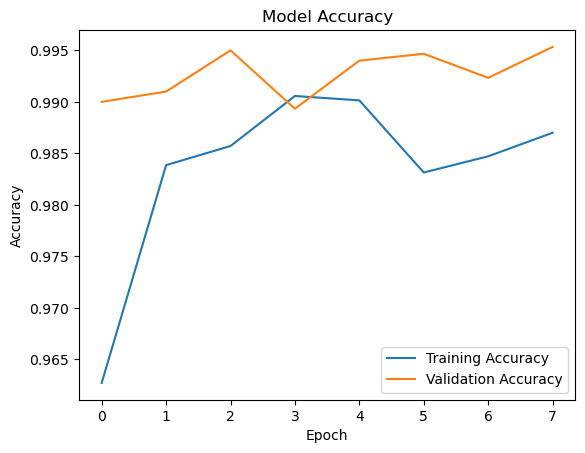

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

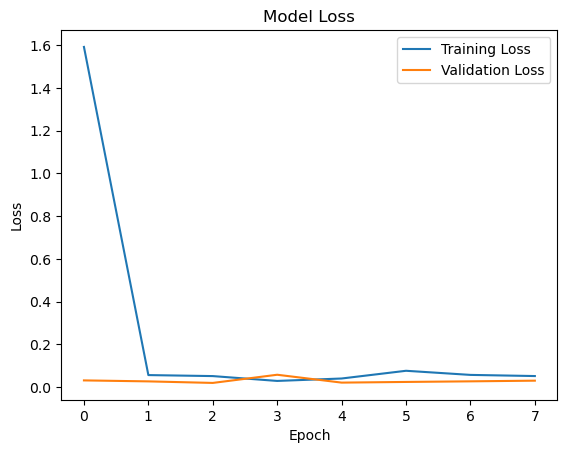

In [23]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
test_generator.reset()  # Reset the test generator to ensure predictions are made on all data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Get True Classes
true_classes = test_generator.classes

# Step 3: Create Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)


188/188 [==============================] - 831s 4s/step


In [28]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
print(cm)

[[753 747]
 [744 756]]


In [31]:
import seaborn as sns

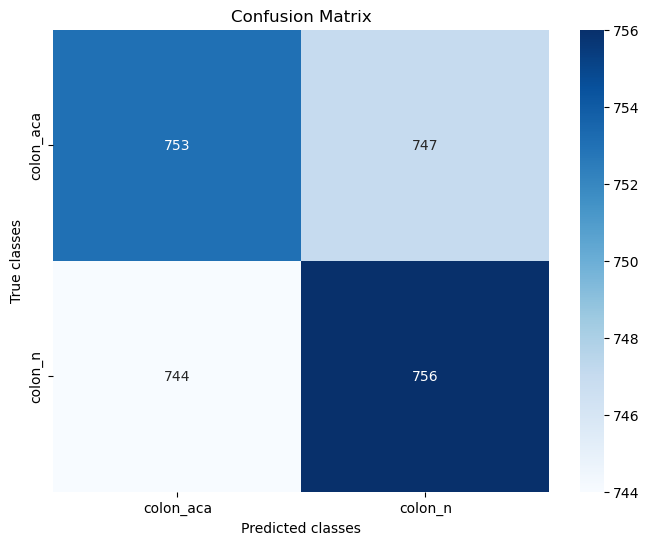

In [32]:
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted classes')
plt.ylabel('True classes')

# Display the plot
plt.show()

In [33]:
from sklearn.metrics import precision_score, recall_score

In [34]:
# Generate predictions on the test set
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Step 2: Get True Classes
true_classes = test_generator.classes

# Step 3: Calculate Precision and Recall
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

188/188 [==============================] - 854s 5s/step


In [35]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.4963
Recall: 0.4963


In [36]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [37]:
# Step 2: Classification Report
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:\n", report)

# Step 3: Precision, Recall, and F1 Score
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Classification Report:
               precision    recall  f1-score   support

   colon_aca       0.50      0.50      0.50      1500
     colon_n       0.50      0.50      0.50      1500

    accuracy                           0.50      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.50      0.50      0.50      3000

Precision: 0.4963
Recall: 0.4963
F1 Score: 0.4963


In [43]:
# Compare true labels with predicted labels
misclassified_indices = [i for i in range(len(true_classes)) if true_classes[i] != predicted_classes[i]]

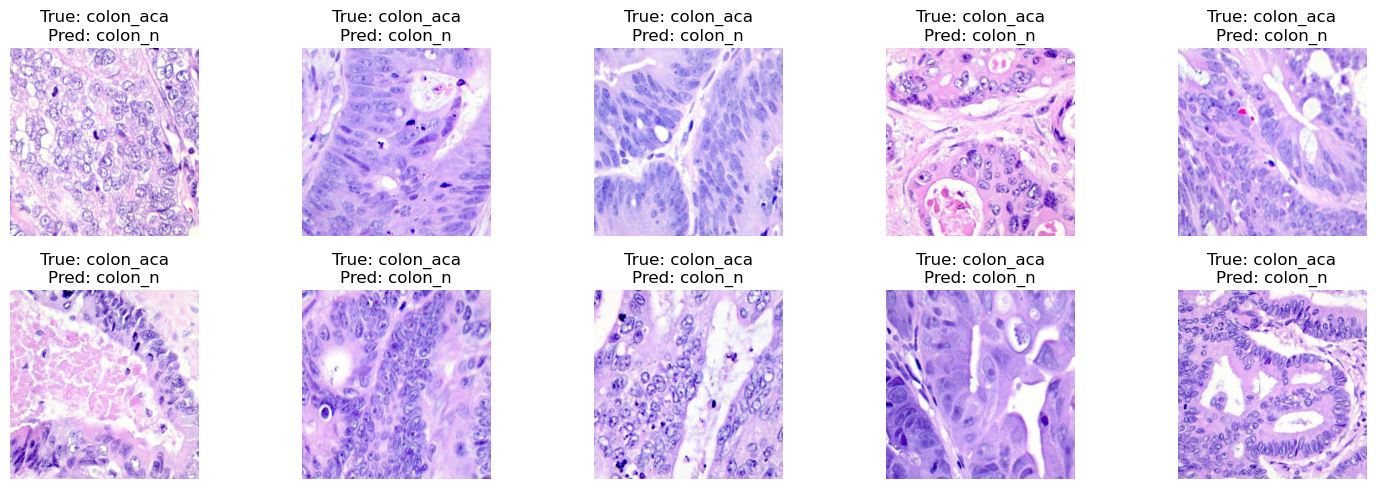

In [44]:
# Set the number of images to display
num_images = min(10, len(misclassified_indices))  # Show up to 10 misclassified images

# Create a figure to display misclassified images
plt.figure(figsize=(15, 5))

# Convert class indices to a list for easier access
class_labels = list(test_generator.class_indices.keys())

for i, index in enumerate(misclassified_indices[:num_images]):
    plt.subplot(2, 5, i + 1)  # Adjust the layout as needed
    img = plt.imread(test_generator.filepaths[index])  # Load the misclassified image
    plt.imshow(img)
    plt.title(f'True: {class_labels[true_classes[index]]}\nPred: {class_labels[predicted_classes[index]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [45]:
# Compare the true class names with the predicted class names
incorrect_predictions = [i for i in range(len(true_classes)) if true_classes[i] != predicted_classes[i]]

# Calculate total number of predictions
total_predictions = len(true_classes)

# Print the number of incorrect predictions and the accuracy
print(f"Total Predictions: {total_predictions}")
print(f"Incorrect Predictions: {len(incorrect_predictions)}")
print(f"Accuracy: {(total_predictions - len(incorrect_predictions)) / total_predictions * 100:.2f}%")

# You can also list the indices of the misclassified images
print(f"Indices of misclassified images: {incorrect_predictions}")

Total Predictions: 3000
Incorrect Predictions: 1511
Accuracy: 49.63%
Indices of misclassified images: [4, 5, 6, 7, 10, 14, 15, 17, 19, 20, 21, 22, 23, 25, 26, 28, 31, 32, 35, 39, 40, 41, 42, 43, 45, 47, 51, 53, 54, 56, 57, 58, 59, 63, 64, 69, 71, 73, 75, 76, 77, 78, 79, 80, 81, 83, 84, 86, 87, 88, 90, 91, 92, 93, 95, 99, 100, 101, 106, 110, 111, 112, 113, 117, 118, 119, 122, 123, 125, 126, 129, 131, 132, 137, 139, 140, 144, 146, 149, 150, 152, 153, 155, 157, 159, 160, 161, 162, 163, 168, 169, 170, 171, 172, 175, 176, 179, 180, 181, 186, 187, 188, 189, 190, 191, 193, 196, 197, 199, 203, 204, 207, 208, 209, 212, 214, 217, 219, 220, 222, 224, 225, 228, 230, 231, 232, 235, 237, 240, 241, 243, 244, 247, 249, 250, 254, 256, 257, 261, 262, 269, 270, 272, 279, 282, 285, 288, 292, 294, 297, 303, 306, 307, 308, 309, 311, 312, 314, 315, 321, 322, 323, 324, 325, 326, 327, 328, 329, 332, 334, 335, 336, 337, 338, 339, 341, 342, 344, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 360, 36

In [46]:
from sklearn.metrics import roc_curve, auc


In [47]:
# Get true labels and predicted probabilities
y_true = test_generator.classes  # True labels
y_pred_prob = model.predict(test_generator)[:, 1]  # Get probabilities for the positive class

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)  

188/188 [==============================] - 1065s 6s/step


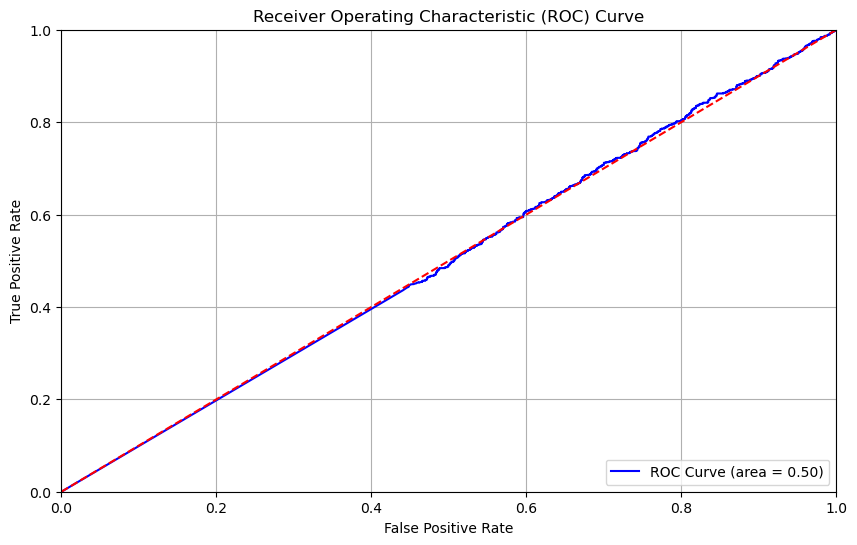

In [48]:
# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()